In [1]:
import numpy as np
import pymc as pm
import arviz as az
import plotly.express as px
import pandas as pd
import aesara.tensor as at

WARNING (aesara.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


10 people

17 chocolates

Each chocolate has some mean appeal and variance of appeal on a latent quality scale

Each person has an individual quality score for each choclate drawn from the appeal distributions for each chocolate

Each person's ranking of the chocolates provides information about whether the quality score for a chocolate is higher or lower than the quality score for another chocolate, but not the specific values on the latent scale

Some chocolates are liked by some people but disliked by others

Some chcocolates are generally agreed to be nicer than others

In [2]:
n_people = 100
n_chocs = 10

np.random.seed(1234)

choc_mus_true = np.random.randn(n_chocs, 1)

choc_ratings_true = np.random.normal(choc_mus_true,
                                1,
                                size=(n_chocs,
                                        n_people))

choc_rankings_true = np.argsort(choc_ratings_true, axis=0)

choc_rankings_true

array([[9, 1, 9, 0, 9, 9, 9, 1, 4, 9, 9, 9, 7, 7, 9, 9, 1, 9, 9, 9, 4, 7,
        9, 9, 9, 9, 1, 9, 1, 9, 9, 9, 9, 1, 9, 1, 9, 9, 4, 9, 9, 9, 9, 7,
        9, 9, 1, 1, 9, 7, 9, 4, 9, 9, 1, 9, 7, 9, 9, 9, 9, 1, 1, 9, 9, 9,
        7, 4, 9, 9, 1, 0, 7, 9, 4, 1, 1, 9, 9, 9, 9, 1, 1, 9, 9, 7, 1, 9,
        4, 9, 9, 9, 9, 9, 4, 9, 1, 9, 9, 9],
       [4, 9, 1, 4, 8, 1, 7, 9, 9, 4, 4, 1, 9, 9, 1, 4, 9, 1, 7, 3, 7, 1,
        1, 4, 4, 1, 4, 4, 9, 4, 7, 1, 8, 0, 6, 4, 8, 7, 1, 4, 4, 7, 1, 1,
        3, 1, 9, 7, 1, 4, 7, 9, 4, 1, 9, 0, 9, 3, 4, 4, 1, 9, 3, 1, 7, 3,
        9, 3, 1, 7, 9, 1, 8, 8, 9, 9, 4, 3, 1, 4, 1, 9, 9, 4, 3, 9, 9, 7,
        9, 1, 1, 1, 1, 1, 9, 1, 9, 1, 4, 7],
       [1, 3, 4, 9, 7, 8, 1, 8, 1, 3, 1, 4, 1, 1, 7, 1, 7, 0, 4, 1, 9, 4,
        3, 7, 7, 5, 8, 8, 7, 7, 4, 8, 4, 6, 3, 9, 3, 4, 9, 6, 7, 0, 8, 4,
        4, 4, 4, 9, 4, 1, 1, 1, 1, 7, 7, 7, 3, 1, 1, 3, 3, 4, 9, 6, 3, 1,
        4, 9, 7, 3, 4, 8, 9, 1, 8, 7, 9, 7, 4, 1, 7, 3, 4, 1, 4, 1, 8, 3,
        1, 4, 8, 3, 4,

In [3]:
with pm.Model() as model:
    
    # overall distribution of mean preference values for chocolates
    choc_mus_fitted = pm.Normal("choc_mus_fitted",
                            0,
                            1,
                            shape=(n_chocs))

    # calculate standard deviation of fitted mu values to normalise scale of person ratings
    choc_mus_std = pm.Deterministic("choc_mus_std",
                                    at.std(choc_mus_fitted))

    #individual distributions of preferences across chocolates, hierarchically related to overall means      
    
    person_ratings = dict()

    for j in range(n_people):
        person_ratings[j] = pm.Normal("person_ratings_"+str(j),
                                        choc_mus_fitted[choc_rankings_true[:,j]]/choc_mus_std,
                                        1,
                                        transform=pm.distributions.transforms.ordered,
                                        initval=np.linspace(-2, 2, num=n_chocs),
                                        shape=n_chocs)
    
    idata = pm.sample(draws=200)

Only 200 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [choc_mus_fitted, person_ratings_0, person_ratings_1, person_ratings_2, person_ratings_3, person_ratings_4, person_ratings_5, person_ratings_6, person_ratings_7, person_ratings_8, person_ratings_9, person_ratings_10, person_ratings_11, person_ratings_12, person_ratings_13, person_ratings_14, person_ratings_15, person_ratings_16, person_ratings_17, person_ratings_18, person_ratings_19, person_ratings_20, person_ratings_21, person_ratings_22, person_ratings_23, person_ratings_24, person_ratings_25, person_ratings_26, person_ratings_27, person_ratings_28, person_ratings_29, person_ratings_30, person_ratings_31, person_ratings_32, person_ratings_33, person_ratings_34, person_ratings_35, person_ratings_36, person_ratings_37, person_ratings_38, person_ratings_39, person_ratings_40, person_ratings_41, person_ratings_42, person_ratings_43, pers

Sampling 2 chains for 1_000 tune and 200 draw iterations (2_000 + 400 draws total) took 2776 seconds.


array([[<AxesSubplot: title={'center': 'choc_mus_fitted'}>,
        <AxesSubplot: title={'center': 'choc_mus_fitted'}>]], dtype=object)

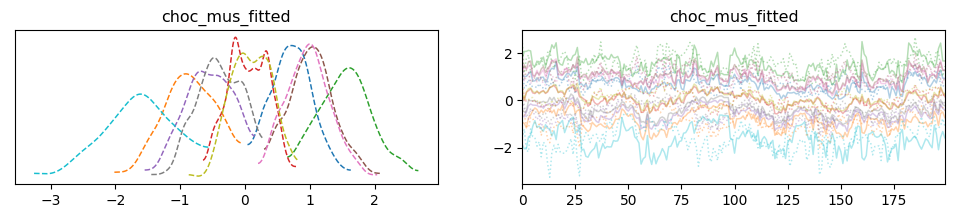

In [4]:
az.plot_trace(idata.posterior, var_names=['choc_mus_fitted'], combined=True)

In [5]:
fig = px.violin(idata.posterior.data_vars['choc_mus_fitted'][0,:,:])
for i in range(0, n_chocs):

    fig.add_shape(
        type='line',
        x0=(i-0.5),
        y0=(choc_mus_true[i,0]),
        x1=i+0.5,
        y1=(choc_mus_true[i,0]),
        line=dict(
            color='Red',
        )
    )


fig.update_layout(
{
'plot_bgcolor': 'rgba(0, 0, 0, 0)',
'paper_bgcolor': 'rgba(0, 0, 0, 0)'
},
showlegend=False)

fig.update_xaxes(showline=True, linewidth=1, linecolor='black', title='chocolate')
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',title='underling preference')


fig.show()